In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
if not os.path.exists('../data/jamb_exam_results.csv'):
    !wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

In [3]:
df = pd.read_csv('../data/jamb_exam_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.reset_index(drop=True, inplace=True)
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,student_id,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [4]:
del df['student_id']
df.fillna(0, inplace=True)
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

df_features = df.drop('jamb_score', axis=1)
y = df.jamb_score.values


df_full_train_X, df_test_X, df_full_train_y, df_test_y = train_test_split(df_features, y, test_size=0.2, random_state=1)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(df_full_train_X, df_full_train_y, test_size=0.25, random_state=1)


df_train_X = df_train_X.reset_index(drop=True)
df_val_X = df_val_X.reset_index(drop=True)
df_test_X = df_test_X.reset_index(drop=True)


dv = DictVectorizer(sparse=True)

train_dicts = df_train_X.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val_X.to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test_X.to_dict(orient='records')
X_test = dv.transform(test_dicts)

y_train = df_train_y
y_val = df_val_y 
y_test = df_test_y


In [6]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [7]:
# Get feature names from DictVectorizer
feature_names = dv.get_feature_names_out()

feature_importances = dt.feature_importances_

split_feature = feature_names[feature_importances.argmax()]
print(split_feature)

study_hours_per_week


In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

params = {
    'n_estimators': 10,
    'random_state': 1,
    'n_jobs': -1
}

rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

42.13724207871227


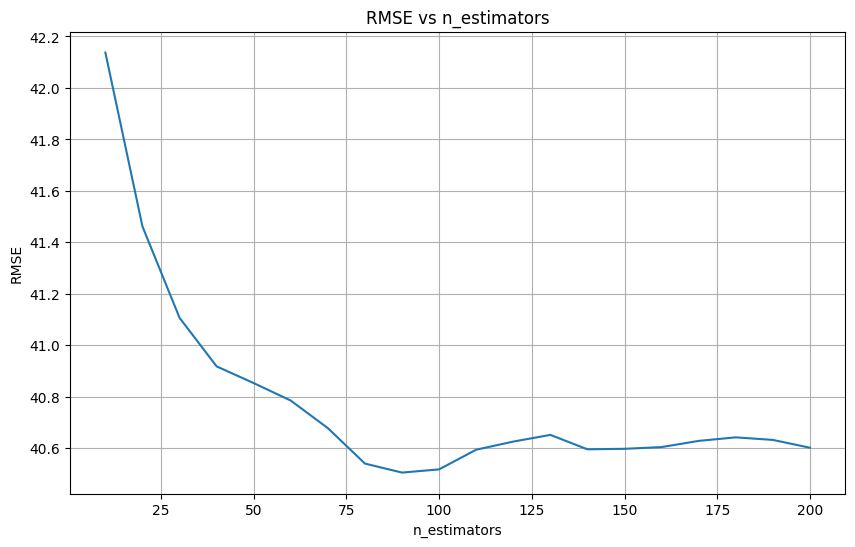

RMSE stops improving at n_estimators = 200


In [10]:
from matplotlib import pyplot as plt
n_estimators_values = range(10, 210, 10)
rmse_scores = []

for n_est in n_estimators_values:
    rf = RandomForestRegressor(
        n_estimators=n_est,
        random_state=1,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)
    
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, rmse_scores)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs n_estimators')
plt.grid(True)
plt.show()

# Print where RMSE stops improving (up to 3 decimal places)
rmse_diff = np.diff([round(x, 3) for x in rmse_scores])
stopping_point = n_estimators_values[np.where(rmse_diff == 0)[0][0] + 1] if len(np.where(rmse_diff == 0)[0]) > 0 else n_estimators_values[-1]
print(f"RMSE stops improving at n_estimators = {stopping_point}")



Mean RMSE for each max_depth:
max_depth=10: 40.392
max_depth=15: 40.735
max_depth=20: 40.740
max_depth=25: 40.788

Best max_depth: 10


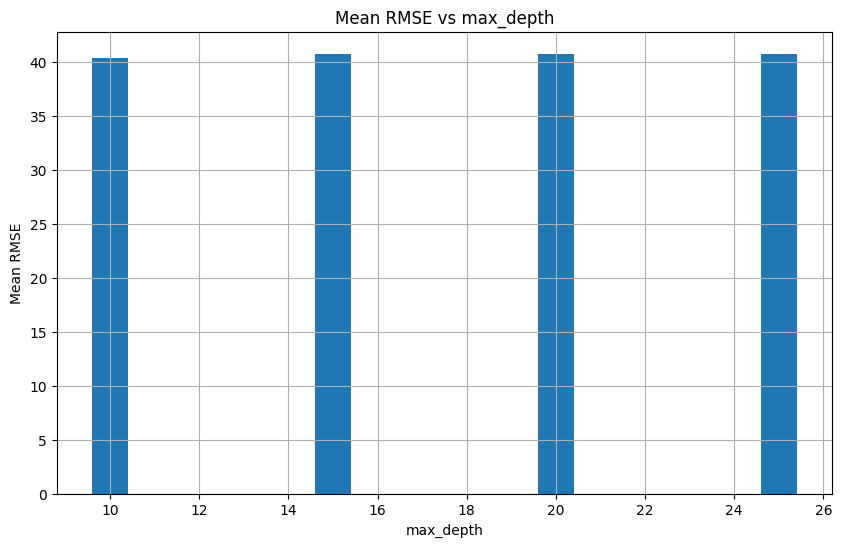

In [11]:
# Try different max_depth values and n_estimators combinations
max_depth_values = [10, 15, 20, 25]
n_estimators_values = range(10, 210, 10)
mean_rmse_by_depth = {}

for max_depth in max_depth_values:
    rmse_scores = []
    
    for n_est in n_estimators_values:
        rf = RandomForestRegressor(
            max_depth=max_depth,
            n_estimators=n_est,
            random_state=1,
            n_jobs=-1
        )
        
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)
    
    mean_rmse_by_depth[max_depth] = np.mean(rmse_scores)


print("\nMean RMSE for each max_depth:")
for depth, rmse in mean_rmse_by_depth.items():
    print(f"max_depth={depth}: {rmse:.3f}")


In [17]:
# Train Random Forest model with specified parameters
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

feature_names = dv.get_feature_names_out()
importances = rf.feature_importances_
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

feature_importance = feature_importance.sort_values('importance', ascending=False)

main_features = ['study_hours_per_week', 'attendance_rate', 'distance_to_school', 'teacher_quality']
main_feature_importance = feature_importance[feature_importance['feature'].isin(main_features)]
print(main_feature_importance)


                 feature  importance
27  study_hours_per_week    0.248354
4        attendance_rate    0.149729
5     distance_to_school    0.136486
28       teacher_quality    0.082682


In [13]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

In [16]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

y_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

[0]	train-rmse:45.49999	val-rmse:47.00533
[1]	train-rmse:44.12948	val-rmse:45.92344


[2]	train-rmse:42.94858	val-rmse:44.98366
[3]	train-rmse:41.90896	val-rmse:44.25755
[4]	train-rmse:40.96728	val-rmse:43.57339
[5]	train-rmse:40.17514	val-rmse:43.11181
[6]	train-rmse:39.40436	val-rmse:42.61054
[7]	train-rmse:38.71199	val-rmse:42.18883
[8]	train-rmse:38.08081	val-rmse:41.86754
[9]	train-rmse:37.57559	val-rmse:41.64338
[10]	train-rmse:37.07490	val-rmse:41.39235
[11]	train-rmse:36.58709	val-rmse:41.14265
[12]	train-rmse:36.14574	val-rmse:40.95201
[13]	train-rmse:35.76896	val-rmse:40.81778
[14]	train-rmse:35.40802	val-rmse:40.75008
[15]	train-rmse:35.08521	val-rmse:40.61341
[16]	train-rmse:34.74187	val-rmse:40.51800
[17]	train-rmse:34.43969	val-rmse:40.41659
[18]	train-rmse:34.16132	val-rmse:40.33546
[19]	train-rmse:33.91836	val-rmse:40.25632
[20]	train-rmse:33.67389	val-rmse:40.25010
[21]	train-rmse:33.45853	val-rmse:40.19826
[22]	train-rmse:33.23371	val-rmse:40.21101
[23]	train-rmse:32.98777	val-rmse:40.14758
[24]	train-rmse:32.80930	val-rmse:40.15079
[25]	train-rmse:32.